In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# kritikseth_fruit_and_vegetable_image_recognition_path = kagglehub.dataset_download('kritikseth/fruit-and-vegetable-image-recognition')

# print('Data source import complete.')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [3]:
kritikseth_fruit_and_vegetable_image_recognition_path = '/home/nickolasz/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8'
print(kritikseth_fruit_and_vegetable_image_recognition_path)

/home/nickolasz/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [4]:
train_dir = kritikseth_fruit_and_vegetable_image_recognition_path + '/train'
val_dir = kritikseth_fruit_and_vegetable_image_recognition_path + '/validation'
test_dir = kritikseth_fruit_and_vegetable_image_recognition_path + '/test'

In [5]:
#Цей набір даних охоплює зображення різних фруктів і овочів, забезпечуючи різноманітну колекцію для завдань розпізнавання зображень. Включені продукти харчування:

#Фрукти : банан, яблуко, груша, виноград, апельсин, ківі, кавун, гранат, ананас, манго
#Овочі : огірок, морква, стручковий перець, цибуля, картопля, лимон, помідор, редис, буряк, капуста, салат, шпинат, соя, цвітна капуста, болгарський перець, перець чилі, ріпа, кукурудза, солодка кукурудза, солодка картопля, паприка, халапеньо, імбир , Часник, Горох, Баклажани

#Набір даних організовано в три основні папки:

#Тренувальні : містить 100 зображень на категорію.
#Тестові: містить 10 зображень на категорію.
#Валідація : містить 10 зображень на категорію.

In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
def imshow(images, labels, class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [10]:
# Отримуємо список класів (назви категорій зображень)
class_names = train_loader.dataset.classes

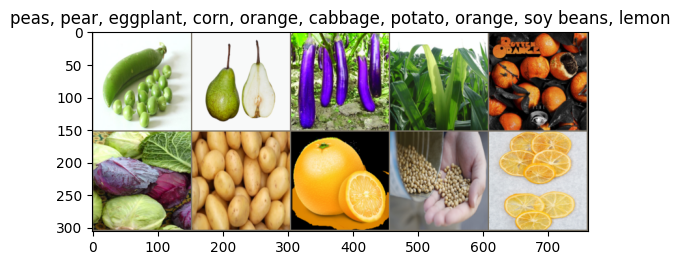

In [11]:
# Виводимо 10 зображень із тренувального набору
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Відображаємо зображення
imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

In [12]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 36
Класи: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Розмір тренувального набору: 3115
Розмір валідаційного набору: 351
Розмір тестового набору: 359

Розподіл класів у тренувальному наборі:
apple: 68
banana: 75
beetroot: 88
bell pepper: 90
cabbage: 92
capsicum: 89
carrot: 82
cauliflower: 79
chilli pepper: 87
corn: 87
cucumber: 94
eggplant: 84
garlic: 92
ginger: 68
grapes: 100
jalepeno: 88
kiwi: 88
lemon: 82
lettuce: 97
mango: 86
onion: 94
orange: 69
paprika: 83
pear: 89
peas: 100
pineapple: 99
pomegranate: 79
potato: 77
raddish: 81
soy beans: 97
spinach: 97
sweetcorn: 91
sweetpotato: 69
tomato: 92
turnip: 98
water

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Обчислити розмір вхідних даних для повнозв'язного шару
        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        # Прокинемо зображення через конволюційні шари, щоб дізнатися розмір
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
model = SimpleCNN(num_classes=36)

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Налаштування тренувального процесу
num_epochs = 12
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

100%|██████████| 98/98 [01:20<00:00,  1.22it/s]


Epoch 1/12:
Train Loss: 6.1718, Train Accuracy: 0.1258
Val Loss: 2.2431, Val Accuracy: 0.3390


100%|██████████| 98/98 [01:24<00:00,  1.15it/s]


Epoch 2/12:
Train Loss: 2.5287, Train Accuracy: 0.2729
Val Loss: 1.7759, Val Accuracy: 0.4587


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Epoch 3/12:
Train Loss: 2.1532, Train Accuracy: 0.3615
Val Loss: 1.3736, Val Accuracy: 0.5812


100%|██████████| 98/98 [01:20<00:00,  1.21it/s]


Epoch 4/12:
Train Loss: 1.9255, Train Accuracy: 0.4157
Val Loss: 1.1886, Val Accuracy: 0.6268


100%|██████████| 98/98 [01:20<00:00,  1.21it/s]


Epoch 5/12:
Train Loss: 1.6624, Train Accuracy: 0.4851
Val Loss: 0.9303, Val Accuracy: 0.6895


100%|██████████| 98/98 [01:19<00:00,  1.24it/s]


Epoch 6/12:
Train Loss: 1.4593, Train Accuracy: 0.5579
Val Loss: 0.9722, Val Accuracy: 0.7293


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch 7/12:
Train Loss: 1.2542, Train Accuracy: 0.6189
Val Loss: 0.7012, Val Accuracy: 0.8091


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Epoch 8/12:
Train Loss: 1.0134, Train Accuracy: 0.6841
Val Loss: 0.5193, Val Accuracy: 0.8547


100%|██████████| 98/98 [01:36<00:00,  1.02it/s]


Epoch 9/12:
Train Loss: 0.8029, Train Accuracy: 0.7528
Val Loss: 0.3948, Val Accuracy: 0.8917


100%|██████████| 98/98 [01:32<00:00,  1.06it/s]


Epoch 10/12:
Train Loss: 0.5734, Train Accuracy: 0.8241
Val Loss: 0.4377, Val Accuracy: 0.9031


100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch 11/12:
Train Loss: 0.4572, Train Accuracy: 0.8565
Val Loss: 0.3567, Val Accuracy: 0.9145


100%|██████████| 98/98 [01:32<00:00,  1.06it/s]


Epoch 12/12:
Train Loss: 0.3713, Train Accuracy: 0.8838
Val Loss: 0.3393, Val Accuracy: 0.9316


In [17]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [18]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.9331
F1 Score: 0.9311


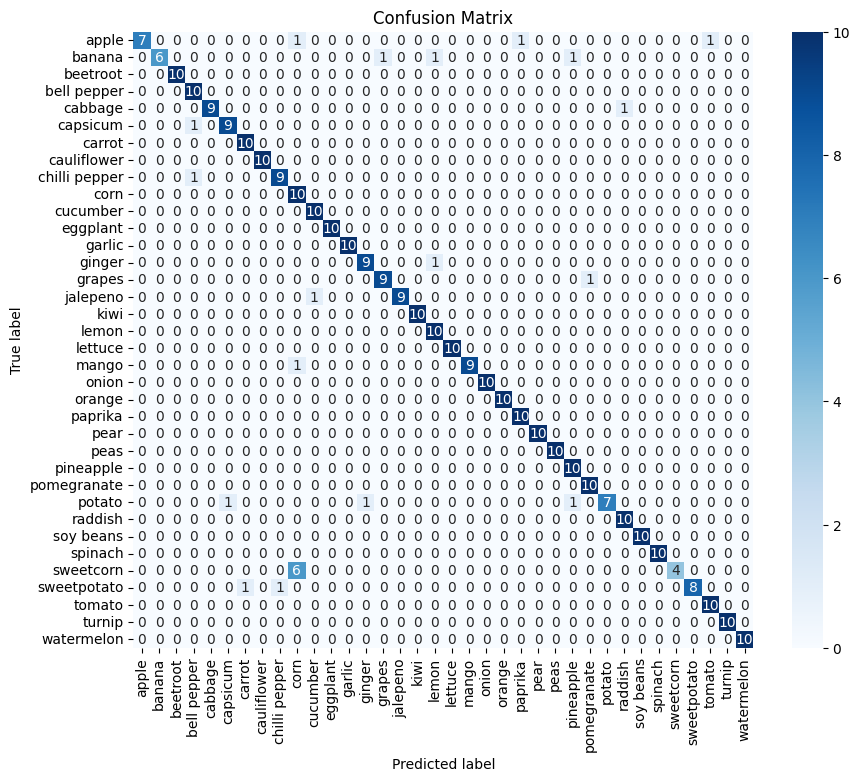

In [20]:
class_names = train_dataset.classes

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

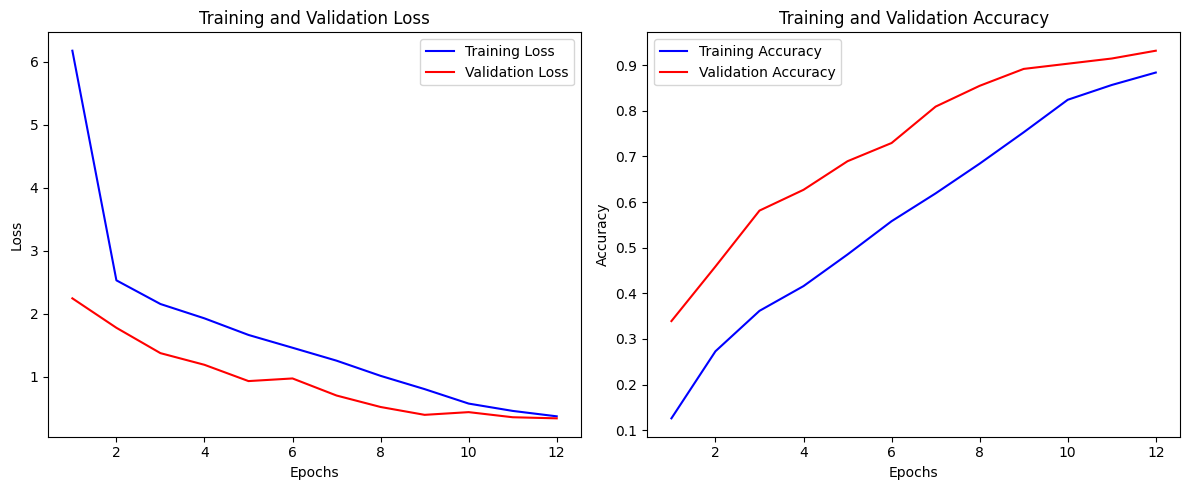

In [21]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

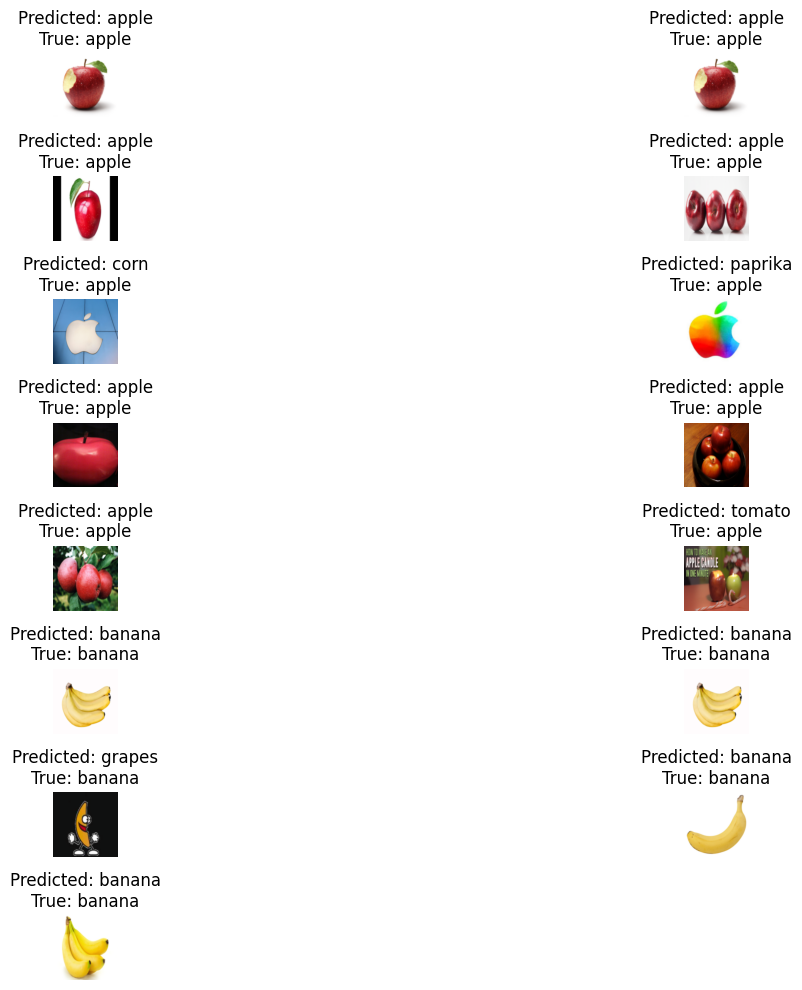

In [22]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)